In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import talib as ta

In [54]:
activo = 'ETH-USD'
df = yf.Ticker(activo)
df = df.history(start='2022-01-01', end='2024-11-20')

In [55]:
# Calculo del MACD
df['MACD'], df['Signal_line'], df['Histogram'] = ta.MACD(df['Close'], fastperiod=12, 
                                                        slowperiod=26, signalperiod=9)

In [56]:
df['SMA200'] = ta.SMA(df['Close'], timeperiod=200)

In [57]:
# Generar señales basadas en MACD
# Señal MACD: 1 = Compra, -1 = Venta
df['MACD_Signal'] = 0
df.loc[df['MACD'] > df['Signal_line'], 'MACD_Signal'] = 1
df.loc[df['MACD'] < df['Signal_line'], 'MACD_Signal'] = -1

# Filtrar señales según la tendencia definida por SMA200
df['Signal'] = 0

# Señales en tendencia alcista
mask_uptrend = df['Close'] > df['SMA200']
df.loc[mask_uptrend & (df['MACD_Signal'] == 1), 'Signal'] = 1

# Señales en tendencia bajista
mask_downtrend = df['Close'] < df['SMA200']
df.loc[mask_downtrend & (df['MACD_Signal'] == -1), 'Signal'] = -1

In [58]:
# Calcular métricas de desempeño del backtesting

# Inicializar variables
initial_balance = 10000
balance = initial_balance
position = 0
returns = []
trade_returns = []
portfolio_values = [initial_balance]
win_trades, loss_trades = [], []

for i in range(1, len(df)):
    if df['Signal'].iloc[i] == 1 and position == 0:  # Compra
        position = balance / df['Close'].iloc[i]
        balance = 0
    elif df['Signal'].iloc[i] == -1 and position > 0:  # Venta
        balance = position * df['Close'].iloc[i]
        trade_return = (balance - initial_balance) / initial_balance
        trade_returns.append(trade_return)
        if trade_return > 0:
            win_trades.append(trade_return)
        else:
            loss_trades.append(trade_return)
        position = 0
    # Calcular valor total
    total_value = balance + (position * df['Close'].iloc[i] if position > 0 else 0)
    returns.append(total_value / portfolio_values[-1] - 1)
    portfolio_values.append(total_value)

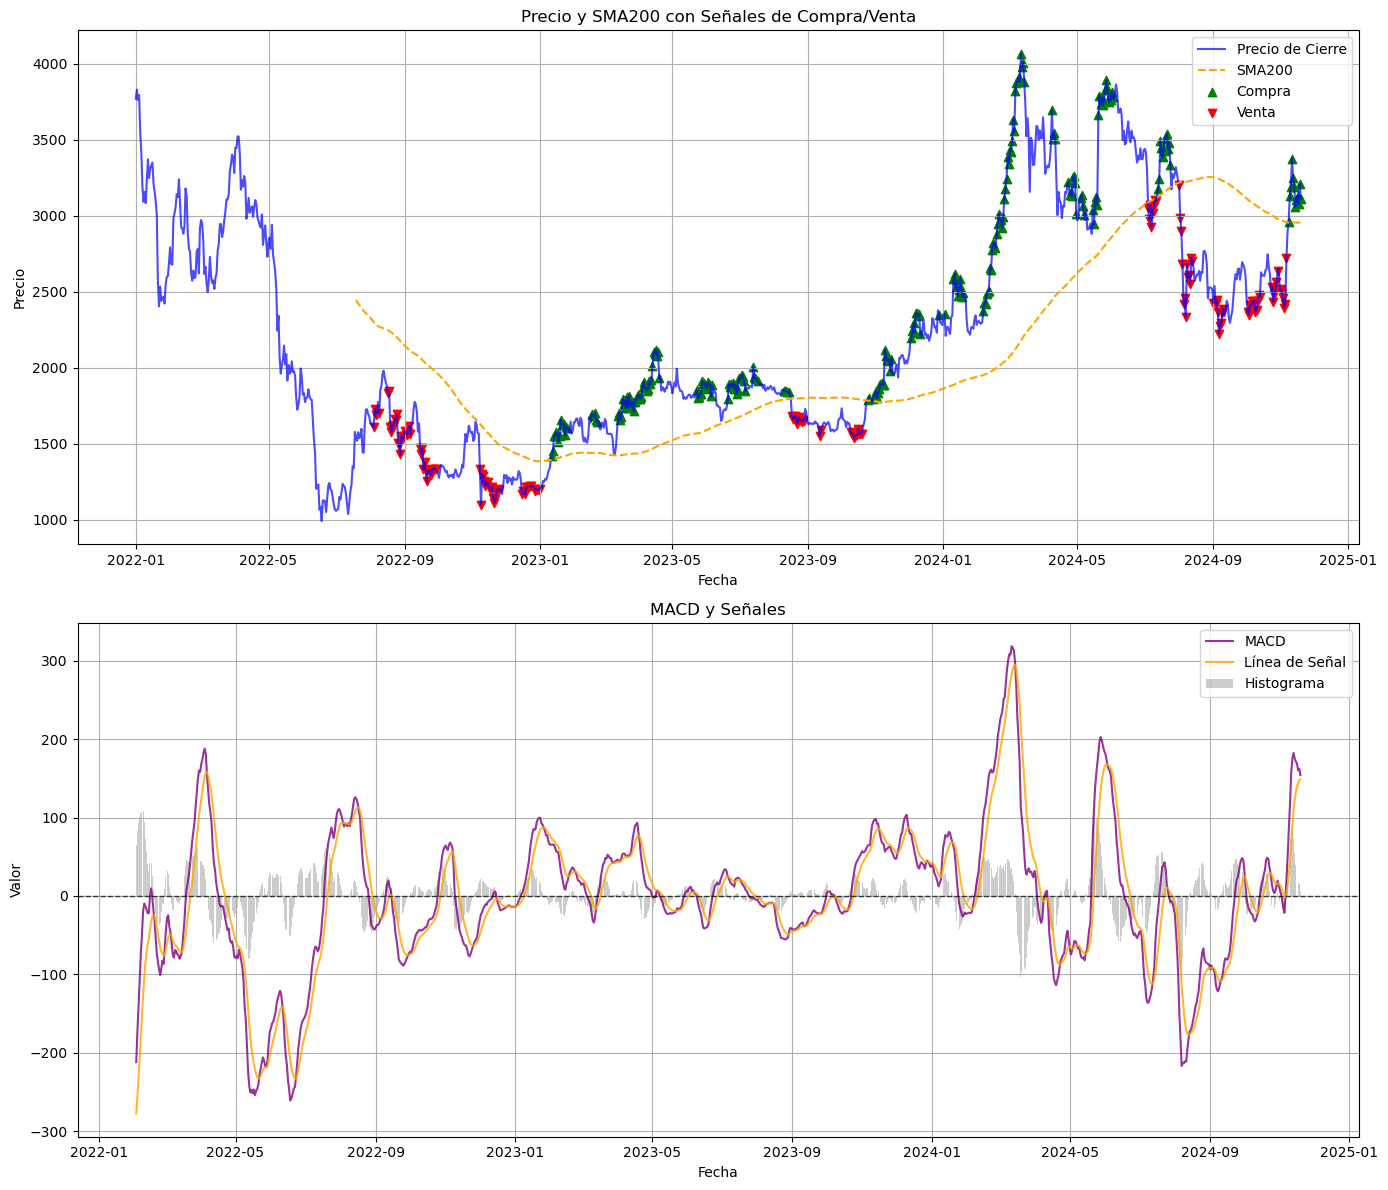

In [59]:
# Gráfico 4: Precio, SMA200, MACD y Señales
plt.figure(figsize=(14, 12))

# Subgráfico 1: Precio y SMA200 con señales de compra y venta
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Precio de Cierre', color='blue', alpha=0.7)
plt.plot(df.index, df['SMA200'], label='SMA200', color='orange', linestyle='--')
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], 
            marker='^', color='green', label='Compra', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], 
            marker='v', color='red', label='Venta', alpha=1)
plt.title('Precio y SMA200 con Señales de Compra/Venta')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid()

# Subgráfico 2: MACD y Señales
plt.subplot(2, 1, 2)
plt.plot(df.index, df['MACD'], label='MACD', color='purple', alpha=0.8)
plt.plot(df.index, df['Signal_line'], label='Línea de Señal', color='orange', alpha=0.8)
plt.bar(df.index, df['Histogram'], label='Histograma', color='gray', alpha=0.4)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.7)
plt.title('MACD y Señales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

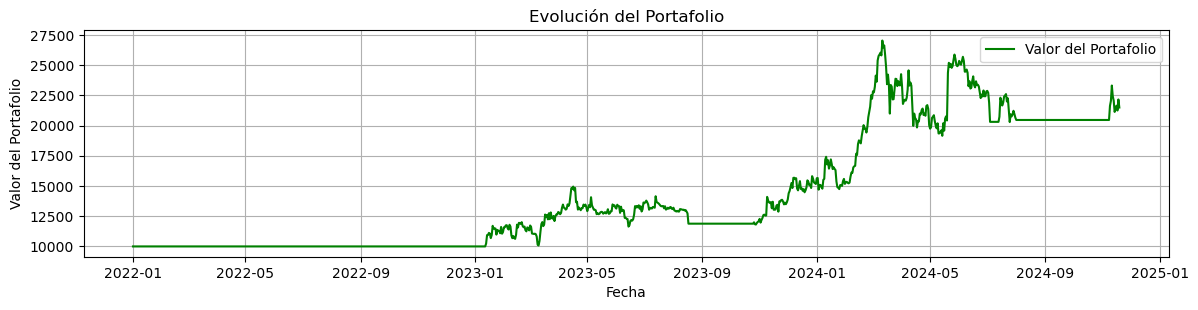

In [60]:
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, portfolio_values, label='Valor del Portafolio', color='green')
plt.title('Evolución del Portafolio')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio')
plt.legend()
plt.grid()

In [61]:
# Cálculo de métricas
total_return = (portfolio_values[-1] / initial_balance) - 1
cagr = (portfolio_values[-1] / initial_balance) ** (1 / ((df.index[-1] - df.index[0]).days / 365.25)) - 1
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else np.nan

In [62]:
# Drawdown máximo
portfolio_values = np.array(portfolio_values)
running_max = np.maximum.accumulate(portfolio_values)
drawdown = (portfolio_values - running_max) / running_max
max_drawdown = drawdown.min()

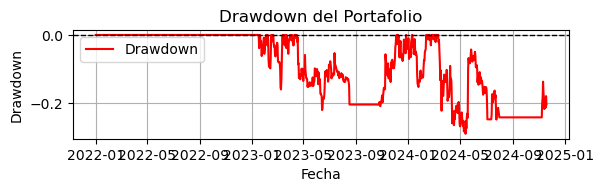

In [63]:
# Gráfico 2: Drawdown
plt.subplot(3, 1, 2)
plt.plot(df.index, drawdown, label='Drawdown', color='red')
plt.title('Drawdown del Portafolio')
plt.xlabel('Fecha')
plt.ylabel('Drawdown')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid()

In [64]:
# Análisis de operaciones
winning_trades = len(win_trades)
losing_trades = len(loss_trades)
win_lose_ratio = (winning_trades / losing_trades) if losing_trades > 0 else np.inf
avg_win = np.mean(win_trades) if winning_trades > 0 else 0
avg_loss = np.mean(loss_trades) if losing_trades > 0 else 0

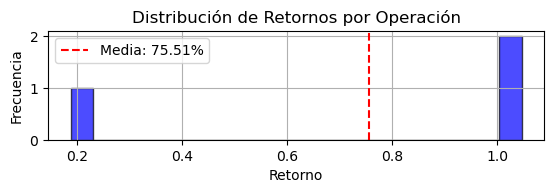

In [65]:
# Gráfico 3: Distribución de Retornos por Operación
plt.subplot(3, 1, 3)
plt.hist(trade_returns, bins=20, edgecolor='black', color='blue', alpha=0.7)
plt.axvline(np.mean(trade_returns), color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {np.mean(trade_returns):.2%}')
plt.title('Distribución de Retornos por Operación')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid()

In [66]:
# Resultados
print(f"Retorno Total: {total_return:.2%}")
print(f"Retorno Anualizado (CAGR): {cagr:.2%}")
print(f"Ratio de Sharpe: {sharpe_ratio:.2f}")
print(f"Drawdown Máximo: {max_drawdown:.2%}")
print(f"Operaciones Ganadoras: {winning_trades} -- Ganancia Media: {avg_win:.2%}")
print(f"Operaciones Perdedoras: {losing_trades} -- Pérdida Media: {avg_loss:.2%}")
print(f"Ratio Ganancias/Pérdidas: {win_lose_ratio:.2f}")

Retorno Total: 114.93%
Retorno Anualizado (CAGR): 30.39%
Ratio de Sharpe: 0.73
Drawdown Máximo: -29.15%
Operaciones Ganadoras: 3 -- Ganancia Media: 75.51%
Operaciones Perdedoras: 0 -- Pérdida Media: 0.00%
Ratio Ganancias/Pérdidas: inf
